# Single Sketch Error: ASF DataSketches vs datasketch

We compare implementations of the HyperLogLog algorithm from the [Apache Software Foundation DataSketches](https://github.com/apache/datasketches-cpp/tree/master/python) library and the open-source python [datasketch](https://github.com/ekzhu/datasketch).  Both libraries present python implementations or bindings for common "sketching" algorithms.
In the writing we abbreviate the two implementations as `ASF:HLL` for the ASF DataSketches 
and `datasketch:HLL` for the other implementation.

This notebook needs easily available libraries that are available on PyPi.

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import datasketches as asf
import datasketch as ds
import mmh3

In [36]:
# Plotting parameters
method_plot_params = {
    "asf" : {"color": "C0", "marker": '.'},
    "datasketch" : {"color": "C1", "marker": "^"}
}
asf_color = method_plot_params["asf"]["color"]
ds__color = method_plot_params["datasketch"]["color"]
q90_ls = "--"

params = {'legend.fontsize': 'x-large',
     'axes.labelsize': 'x-large',
     'axes.titlesize':'x-large',
     'xtick.labelsize':'x-large',
     'ytick.labelsize':'x-large',
      "lines.linewidth": 2.5}
plt.rcParams.update(params)

### <a name="error_vs_cardinality"></a>1. Error vs Cardinality 
We study the error behaviour as the input cardinality increases.  We provide an initial comparison to highlight the differences in the estimators.
These plots are crucial to understanding error distributions of sketches.

To generate the synthetic data, we use "Fibonacci Hashing" as a cheap way to generate a pseudorandom sequence.  This process starts with an initial selection of a $64$-bit integer.  Then, for every new item that must be generated, we add the full $64$ bit range scaled by the integer golden ratio so that every other update _intentionally_ overflows and maps once more back into the $64$ bit range.

#### 1a. Single sketch estimation

From the same directory as this notebook, run

```./cardinality_error_experiment.py -lgk 14 -lgt 7  -lgN 20``` 

which generates $8$ "plot points" between every power of $2$ not exceeding $N = 2^{21}$.  We fix `-lgt 7` for $128$ trials and use a sketch size of with $2^{14}$.  For every trial, a fresh sketch is initialised.  The results are saved in a directory `hll_accuracy_profile_yyymmdd/...`

The two sketches we compare are HyperLogLog sketches with $2^{14}$ buckets:

*ASF DataSketches Sketch Setup*
- `hll = asf.hll_sketch(14)`

*datasketch sketch setup*
- `h = ds.HyperLogLogPlusPlus(p=14, hashfunc=lambda x: mmh3.hash64(x, signed=False)[0])`


In [40]:
asf_errors = pd.read_csv("hll_accuracy_profile_20230504/DataSketches_hll_1516lgK_14_lgT_8trials_256.csv", index_col=0)
ds__errors = pd.read_csv("hll_accuracy_profile_20230504/datasketch_hll_1516lgK_14_lgT_8trials_256.csv", index_col=0)

lgk = 14

Text(0.5, 0, 'Input cardinality $n$')

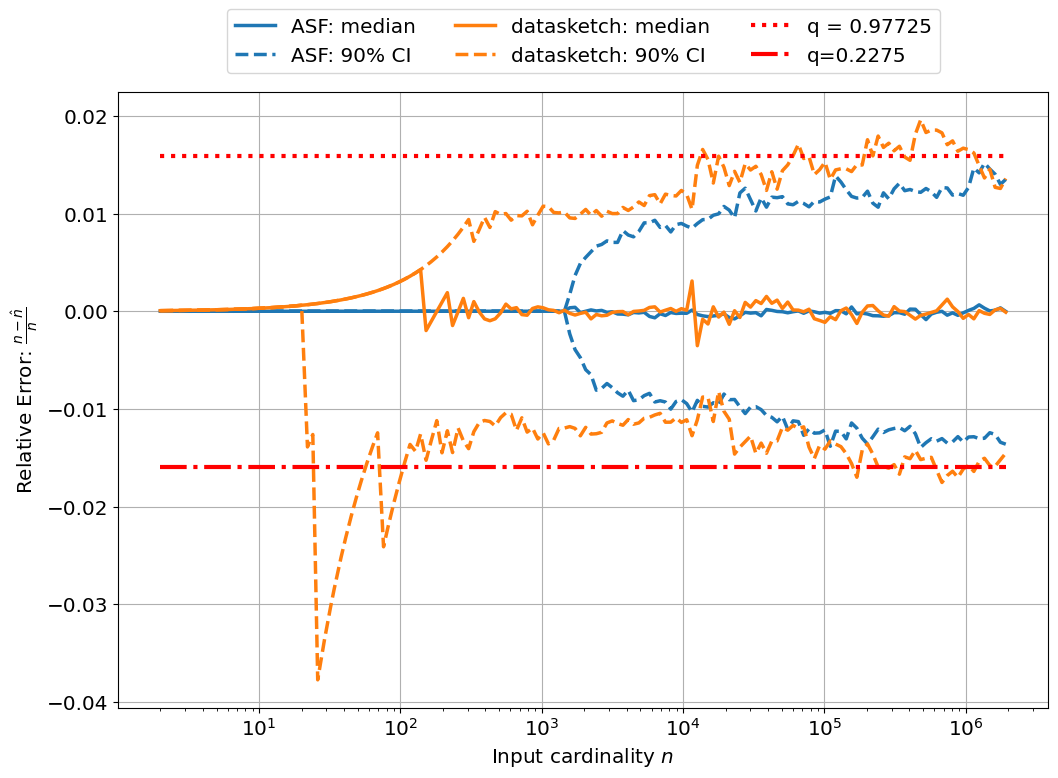

In [41]:
fig, ax = plt.subplots(figsize=(12,8))

methods = ["ASF", "datasketch"]

for i, (method, colour, df) in enumerate(zip(methods, [asf_color, ds__color], [asf_errors, ds__errors])):
    xn = df.index 
    median = df.median(axis=1)
    q95 = df.quantile(q=0.977725, axis=1)
    q05 = df.quantile(q=0.022275, axis=1) # df.mean(axis=1) - df.std(axis=1)
    ax.plot(xn, median,
           color=colour, label=method+": median")
    ax.plot(xn, q95,
           color=colour, linestyle=q90_ls)
    ax.plot(xn, q05,
           color=colour, linestyle=q90_ls, label=method+": 90% CI")

ax.plot(xn, 2.04/np.sqrt(1<<lgk)*np.ones_like(xn), 
        color="red", lw=3., linestyle=":", label="q = 0.97725")
ax.plot(xn, -2.04/np.sqrt(1<<lgk)*np.ones_like(xn), 
        color="red", lw=3., linestyle="-.",  label="q=0.2275")

ax.set_xscale('log', base=10)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15),
          ncol=3, fancybox=True)
ax.grid()
ax.set_ylabel(r"Relative Error: $ \frac{n - \hat{n}}{n}$")
ax.set_xlabel(r"Input cardinality $n$")

**Experiment Summary**

The plotted red lines represent $\pm 2 \sigma$ where, for HLL, the standard error of the estimator is $\sigma = 1.04 / \sqrt{k}$. 
Hence, the area between the red lines is a confidence interval.  We have chosen the quantiles 
$q = 0.022275, 0.977725$ so that the area between the red lines is approximately a $95\%$ confidence interval.
This test uses a number of buckets $k = 2^{14}$.  Changing the number of buckets in the sketch alters the standard error so the red lines, and the behaviour of the error curves at quantile level $q$, would change appropriately.


Both implementations have a median that is centered about an error of $0$, suggesting that they return unbiased estimators of the true cardinality.  At small cardinalities, `asf.hll_sketch` is vastly better than the `datasketch.HyperLogLogPlusPlus`.  This is because it transitions through various estimators to ensure small error.  All of the curves for `ASF:HLL` have zero error until about $n = 10^3$ is in sparse mode and an exact estimator can be used.  Without this behavior and resorting to the standard change of estimators as reported in [Figure 3](https://static.googleusercontent.com/media/research.google.com/en//pubs/archive/40671.pdf) can cause the wild error curves at small cardinalities.  It is important to be accurate on low cardinality inputs as many big data streams are power-law distributed, so only a few have extremely large cardinality, while many might be have small cardinality.

At large cardinalities, _for a single sketch_, `asf.hll_sketch` uses the HIP estimator which mildly improves on the standard large cardinality estimator.  However, when we need to merge sketches later on, this behaviour will revert to the standard HLL estimator.

### 2.  Single sketch estimation: Real data
Now let's see what happens when we want sketch some real data.  
We will download an opensource dataset from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/BitcoinHeistRansomwareAddressDataset#).


In [42]:
!curl -o bitcoin.zip "https://archive.ics.uci.edu/ml/machine-learning-databases/00526/data.zip"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  110M    0  110M    0     0  1150k      0 --:--:--  0:01:38 --:--:-- 1231k8k      0 --:--:--  0:00:23 --:--:-- 1164k 0     0   913k      0 --:--:--  0:00:30 --:--:-- 1065k 1193k      0 --:--:--  0:01:09 --:--:-- 1544k


In [43]:
!unzip bitcoin.zip

Archive:  bitcoin.zip
  inflating: BitcoinHeistData.csv    


In [44]:
bitcoin_df = pd.read_csv("BitcoinHeistData.csv", header=0)
bitcoin_df.head()

,address,year,day,length,weight,count,looped,neighbors,income,label
0,111K8kZAEnJg245r2cM6y9zgJGHZtJPy6,2017,11,18,0.008333,1,0,2,100050000.0,princetonCerber
1,1123pJv8jzeFQaCV4w644pzQJzVWay2zcA,2016,132,44,0.000244,1,0,1,100000000.0,princetonLocky
2,112536im7hy6wtKbpH1qYDWtTyMRAcA2p7,2016,246,0,1.000000,1,0,2,200000000.0,princetonCerber
3,1126eDRw2wqSkWosjTCre8cjjQW8sSeWH7,2016,322,72,0.003906,1,0,2,71200000.0,princetonCerber
4,1129TSjKtx65E35GiUo4AYVeyo48twbrGX,2016,238,144,0.072848,456,0,1,200000000.0,princetonLocky


Let's focus on the simple task of counting how many unique addresses are present in the dataset.
With native pandas functionality, we see that there are about $2.6$ million unique addresses.
We will use HLL sketches to estimate this count.

In [45]:
%%time
true_count = bitcoin_df["address"].nunique()

CPU times: user 811 ms, sys: 33.8 ms, total: 845 ms
Wall time: 846 ms


In [46]:
print(f"There are {true_count} unique addresses")

There are 2631095 unique addresses


Now define equivalent sketches from both libraries.
We use $2^{14}$ buckets and $8$-bit HyperLogLog sketches for each implementation.  The `datsketch:HLL` uses the MurmurHash library so that we have equivalent sketches for comparison. 

In [47]:
asf_hll = asf.hll_sketch(14, asf.HLL_8)
ds_hll = ds.HyperLogLogPlusPlus(p=14,  hashfunc=lambda x: mmh3.hash64(x, signed=False)[0])

In [48]:
%%time
for ad in bitcoin_df["address"]:
    asf_hll.update(ad)

CPU times: user 2.08 s, sys: 8.87 ms, total: 2.08 s
Wall time: 2.09 s


In [49]:
%%time
for ad in bitcoin_df["address"]:
    ds_hll.update(ad)

CPU times: user 3.65 s, sys: 10.4 ms, total: 3.66 s
Wall time: 3.66 s


On this simple example we see that the datasketches implementation takes about $2$ seconds compared to almost $4$ for `datasketch`.  Note that these times are longer than for the native Pandas call to nunique; this is not a problem because, unlike `pd.nunique(.)` the sketches are designed for large datasets not entirely held in memory.  The figures quoted are on a $2023$ Apple Macbook Pro with Apple M1 Pro and absolute numbers may differ slightly.

For estimation accuracy, we have the following behaviour for the single sketches.  Since we have the true count, we can also evaluate the error.

In [50]:
# DataSketches
print(f"ASF estimate: {asf_hll.get_estimate():.4f}")
print(f"ASF error: {100*(asf_hll.get_estimate()-true_count)/true_count:.4f}  %")

ASF estimate: 2650083.4660
ASF error: 0.7217  %


In [51]:
# Datasketch
print(f"datasketch estimate: {ds_hll.count():.4f}")
print(f"datasketch error: {100*(ds_hll.count() - true_count)/true_count:.4f}  %")

datasketch estimate: 2646133.7361
datasketch error: 0.5716  %


On this example, the datasketch implementation has a lower error than the ASF method.  However, this was a single sketch so we cannot draw any strong conclusions.  Rather, we would have to study the error distribution as previously done in [Section 1](error_vs_cardinality).  

We run $25$ independent trials of each algorithm, each trial with a fresh sketch.
Since HLL is deterministic given the hash seed, with no change to the input we would obtain the same output every time.  To avoid this, we prepend the trial number to every incoming string so that the number of unique items remains the same but the streams are superficially different.

In [52]:
lgk = 14
num_trials = 25

all_asf_hll = [asf.hll_sketch(14, asf.HLL_8) for _ in range(num_trials)]
all_ds_hll = [ds.HyperLogLogPlusPlus(p=14,  hashfunc=lambda x: mmh3.hash64(x, signed=False)[0]) for _ in range(num_trials)]

asf_hll_estimates = np.zeros((num_trials,), dtype=float)
asf_hll_errors = np.zeros_like(asf_hll_estimates)
ds__hll_estimates = np.zeros_like(asf_hll_estimates)
ds__hll_errors = np.zeros_like(asf_hll_estimates)

In [53]:
%%time
for trial in range(num_trials):
    for ad in bitcoin_df["address"]:
        all_asf_hll[trial].update(str(trial) + ad)
    asf_hll_estimates[trial] = all_asf_hll[trial].get_estimate()

CPU times: user 57.9 s, sys: 131 ms, total: 58 s
Wall time: 58.2 s


In [54]:
%%time
for trial in range(num_trials):
    for i, ad in enumerate(bitcoin_df["address"]):
        all_ds_hll[trial].update(str(trial) + ad)
    ds__hll_estimates[trial] = all_ds_hll[trial].count()

CPU times: user 1min 41s, sys: 266 ms, total: 1min 41s
Wall time: 1min 41s


The ASF HLL runs in about half of the time as the datasketch implementation.
However, we are also interested in the distribution of errors for each sketch implementation.
Since we have fewer trials than in Section 1, we plot a box and whisker diagram which is still useful in understanding the error distribution, despite being less informative about the full error distribution than the pitchfork plots from Section 1.  The plot can be interpreted as a cross-section of the pitchfork plot at the vertical line $n = 2631095$.

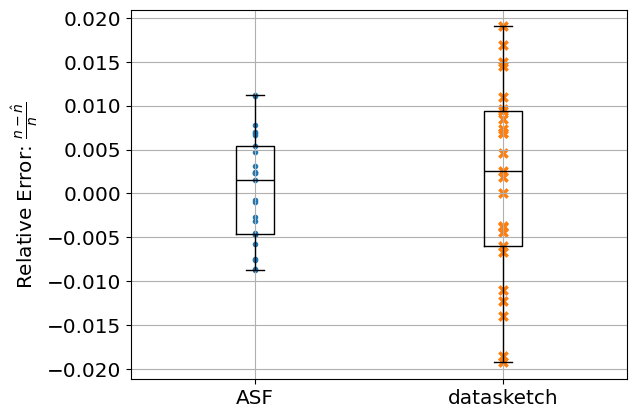

In [55]:
asf_hll_errors = (asf_hll_estimates - true_count) / true_count
datasketch_hll_errors = (ds__hll_estimates - true_count) / true_count

for arr in [asf_hll_errors, datasketch_hll_errors]:
    arr.sort()

fig, ax = plt.subplots()
error_data = {"ASF": asf_hll_errors, "datasketch": datasketch_hll_errors}

#
box_plot = ax.boxplot(list(error_data.values()), vert=True)
for median in box_plot['medians']:
    median.set_color('black')
    


ax.scatter(np.ones_like(asf_hll_errors), asf_hll_errors,  marker=".")
ax.scatter(2*np.ones_like(datasketch_hll_errors), datasketch_hll_errors, marker="x")
ax.set_xticks([1,2], list(error_data.keys()))
ax.set_ylabel(r"Relative Error: $ \frac{n - \hat{n}}{n}$")
ax.grid()

The error statistics from the experiment are as follows.

In [62]:
experiment_error_statistics = {
    "ASF": {"median" : None, "IQR" : None}, 
    "datasketch": {"median" : None, "IQR" : None}
}
key_list = list(experiment_error_statistics.keys())

for i, m in enumerate(box_plot["medians"]):
    method_median = m.get_data()[1][0]
    experiment_error_statistics[key_list[i]]["median"] = method_median

for i, line in enumerate(box_plot["boxes"]):
    liney = line.get_ydata()
    iqr = liney.max() - liney.min()
    experiment_error_statistics[key_list[i]]["IQR"] = iqr

In [61]:
experiment_error_statistics

{'ASF': {'median': 0.0015215127060363715, 'IQR': 0.009980189698406661},
 'datasketch': {'median': 0.0025901816561035075, 'IQR': 0.015456189289630978}}

In [70]:
print("{:<12}{:>14}{:>14}".format("Library", "Median Error", "IQR"))
print("-"*40)
for k,vd in experiment_error_statistics.items():
    print("{:<12}{:>14.4f}{:>14.4f}".format(k, vd["median"], vd["IQR"]))
    
print("\n"*2)
print("{:<12}{:>14}{:>14}".format("ErrorxChange", "Median Error", "IQR"))
print("-"*40)
median_factor = experiment_error_statistics["ASF"]["median"] / experiment_error_statistics["datasketch"]["median"]
iqr_factor = experiment_error_statistics["ASF"]["IQR"] / experiment_error_statistics["datasketch"]["IQR"]
print("{:<12}{:>14.4f}{:>14.4f}".format("", median_factor, iqr_factor))

Library       Median Error           IQR
----------------------------------------
ASF                 0.0015        0.0100
datasketch          0.0026        0.0155



ErrorxChange  Median Error           IQR
----------------------------------------
                    0.5874        0.6457


The columns in the second table above are found by taking the ratio of the smaller ASF results and the larger datasketch results.  
They indicate that the median error in using the ASF library is about $58\%$ of that incurred when using the datasketch library and the interquartile range is tighter, being about $65\%$ as large as that from the `datasketch` implementation.